In [ ]:
# If you don't have some of these packages, please install them with pip or conda before running the file.

import os
import glob
import random
import shutil
import cv2
from imutils import paths
import argparse
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array

Dataset: https://www.kaggle.com/jonathanoheix/face-expression-recognition-dataset

__NOTE__: This file needs to be in the same folder as your "images" folder. Run this file on the original dataset downloaded from Kaggle.

### Orignial count of dataset before any preprocessing

In [536]:
# Count of images in train folder
for folder in os.listdir('images/train'):
    train_count = len(os.listdir(f'images/train/{folder}'))
    print(f'{folder}: {train_count}')

angry: 3000
disgust: 2789
fear: 3000
happy: 3000
neutral: 3000
sad: 3000
surprise: 2936


In [537]:
# Count of images in validation folder
for folder in os.listdir('images/validation'):
    valid_count = len(os.listdir(f'images/validation/{folder}'))
    print(f'{folder}: {valid_count}')

angry: 300
disgust: 200
fear: 300
happy: 300
neutral: 300
sad: 300
surprise: 300


In [ ]:
# List of labels
labels = os.listdir('images/train')
labels

## Preprocessing

I performed the following preprocessing steps:

1. Remove duplicated images. Some images appear in multiple folders (e.g. the same image appears in both Fear and Angry folders)
2. Remove bad/corrupted images.
3. Balance out the number of images for each label by removing images and data augmentation

### Combine all images from train and validation folders to one combined folder

Because there are duplicated images in the dataset, we can't guarantee that the same image doesn't appear in both train folder and validation folder. There are also bad images in both folders.

That's why it's easier to combine all images to just run functions that identify bad images on all images at once.

__Note__: the images are still categorized by emotion labels.

In [ ]:
# Create combined folder
os.makedirs('images/combined')

# Create an empty folder for each label inside the combined folder
for label in labels:
    os.makedirs(f'images/combined/{label}')
    print('Success')

In [ ]:
# Moving all images from train and validation folders to combined folder
for folder in os.listdir('images/validation'):
    for filename in os.listdir(f'images/validation/{folder}'):
        shutil.move(f'images/validation/{folder}/{filename}', f'images/combined/{folder}')

for folder in os.listdir('images/train'):
    for filename in os.listdir(f'images/train/{folder}'):
        shutil.move(f'images/train/{folder}/{filename}', f'images/combined/{folder}')

### At this point, make sure that your train folder and validation folder are all empty because later on we will distribute images back to these folders.

You can rerun cells 2 and 3 above to check the count again.

### Remove duplicated images

The code is adapted from this article: https://www.pyimagesearch.com/2020/04/20/detect-and-remove-duplicate-images-from-a-dataset-for-deep-learning/

The main idea is generating hash code for each image based on its pixels. Duplicated images will have the same hash code and will be grouped together. After that, we will remove the duplicates.


In [ ]:
def generate_hash(image, hashSize=8):
	# convert the image to grayscale and resize the grayscale image,
	# adding a single column (width) so we can compute the horizontal
	# gradient
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	resized = cv2.resize(gray, (hashSize + 1, hashSize))

	# compute the (relative) horizontal gradient between adjacent
	# column pixels
	diff = resized[:, 1:] > resized[:, :-1]

	# convert the difference image to a hash and return it
	return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

In [99]:
# grab the paths to all images in our input dataset directory and
# then initialize our hashes dictionary
imagePaths = list(paths.list_images('images/combined'))

In [100]:
hashes = {}
# loop over our image paths
for imagePath in imagePaths:
	# load the input image and compute the hash
	image = cv2.imread(imagePath)
	hash_code = generate_hash(image)

	# grab all image paths with that hash, add the current image
	# path to it, and store the list back in the hashes dictionary
	image_paths = hashes.get(hash_code, [])
	image_paths.append(imagePath)
	hashes[hash_code] = image_paths

This block of code will display the duplicated images in a new window for you to examine if the grouped pictures are actual duplicates.

When the image window opens, press any key to display the next image. To close the window, interrupt the notebook connection. Once you see that the code correctly detects duplicates, you can proceed with the next cell to remvoe these images.

In [103]:
# loop over the image hashes
for (h, hashedPaths) in hashes.items():
    # check to see if there is more than one image with the same hash
    if len(hashedPaths) > 1:
        # initialize a montage to store all images with the same
        # hash
        montage = None
        # loop over all image paths with the same hash
        for p in hashedPaths:
            print(p)
            # load the input image and resize it to a fixed width
            # and height
            image = cv2.imread(p)
            image = cv2.resize(image, (150, 150))

            # if our montage is None, initialize it
            if montage is None:
                montage = image

            # otherwise, horizontally stack the images
            else:
                montage = np.hstack([montage, image])

        # show the montage for the hash
        # print("[INFO] hash: {}".format(h))
        cv2.imshow("Montage", montage)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

The next block of code will delete the duplicated images from the folder. When I ran the code on my files, 1904 images were deleted. You should get around this number.

In [104]:
# loop over the image hashes
count = 0
for (h, hashedPaths) in hashes.items():
    # check to see if there is more than one image with the same hash
    if len(hashedPaths) > 1:
        for p in hashedPaths[1:]:
            os.remove(p)

            print('removed ', p)
            count += 1
            print(count)

In [522]:
# Check the count of images after removing duplicates
for folder in os.listdir('images/combined'):
    count = len(os.listdir(f'images/combined/{folder}'))
    print(f'{folder}: {count}')

angry: 4717
disgust: 447
fear: 4797
happy: 8792
neutral: 6035
sad: 5902
surprise: 3236


### Remove bad images

Below are some examples of bad/corrupted images. They either cannot display the original images or they are not human faces.

<img src='images-old\Bad\2059.jpg' />
<img src='images-old\Bad\2809.jpg' />
<img src='images-old\Bad\6458.jpg' />
<img src='images-old\Bad\5722.jpg' />
<img src='images-old\Bad\8030.jpg' />

Unfortunately, this part is pretty manual. You don't have to go through thousands of images but you still have to delete the bad ones manually once you get the file name.

The general idea is to count the number of black and white pixels and look at the ones that have highest number of black pixels or highest number of white pixels. Because most of these bad pictures are mostly black or mostly white.

You might also find some duplicates in this step. Make sure to delete those as well.

In [464]:
# Counting number of black pixels
black_pixels = {}

folder = 'surprise' #change this for each folder

for filename in os.listdir(f'images/combined/{folder}'):
    # Load image and change to grayscale color
    image = cv2.imread(f'images/combined/{folder}/{filename}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find black pixels, count them, and assign the count to the image file
    number_of_black_pix = np.sum(image == 0) 
    black_pixels[filename] = number_of_black_pix

# Sort the list of images by the highest count of black pixels
reverse = reversed(sorted(black_pixels, key=black_pixels.get))

images/combined/surprise/9703.jpg


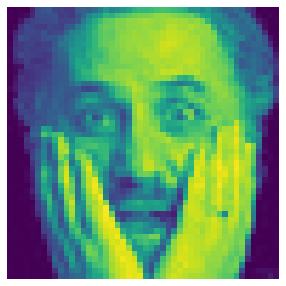

In [487]:
# Rerun this cell to print out the next image on the list
# If you see that the image is not a human face, copy the file name and find it in your images folder then delete it
# You can just look at 10 images with the highest black pixels count to get most of the bad images

img_path = f'images/combined/{folder}/{next(reverse)}'
print(img_path)
image = plt.imread(img_path)
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(image)

Do the same thing for white pixels. There are not a lot of bad images with high white pixels.

In [488]:
# Counting number of white pixels
white_pixels = {}

for filename in os.listdir(f'images/combined/{folder}'):
    # Load image and change to grayscale color
    image = cv2.imread(f'images/combined/{folder}/{filename}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Find white pixels, count them, and assign the count to the image file
    number_of_white_pix = np.sum(image == 255) 
    white_pixels[filename] = number_of_white_pix

# Sort the list of images by the highest count of white pixels
reverse = reversed(sorted(white_pixels, key=white_pixels.get))

images/combined/surprise/30322.jpg


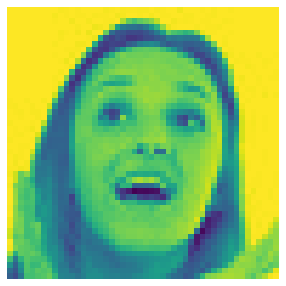

In [521]:
# Rerun this cell to print out the next image on the list
# If you see that the image is not a human face, copy the file name and find it in your images folder then delete it
# You can just look at 10 images with the highest white pixels count to get most of the bad images

img_path = f'images/combined/{folder}/{next(reverse)}'
print(img_path)
image = plt.imread(img_path)
plt.figure(figsize=(5, 5))
plt.axis('off')
plt.imshow(image)

Even after these processes, we still can't guarantee that there are no duplicates and corrupted images left but we removed as many as we could

### Balance out the number of images in each label

The target count is:
- Train set: around 3000 images in each label
- Validation set: 300 images in each label (Disgust only has 200)
- Test set: around 200 images in each label

We will move images to validation folder first.

Then remove images from all folders except Disgust and Surprise to decrease the image count in these folder.

Then augment data in Disgust folder to increase the image count in these folder.

Surprise folder has enough for train and validation data so we don't have to do anything

Lastly, for test set, we can use some images from this dataset: https://github.com/muxspace/facial_expressions

In [529]:
# Move 300 images each label to validation folder (except Disgust folder)
for folder in os.listdir('images/combined'):
    print('moving images in', folder)

    if folder == 'disgust':
        count = 200
    else:
        count = 300

    for filename in random.sample(os.listdir(f'images/combined/{folder}'), count):
        shutil.move(f'images/combined/{folder}/{filename}', f'images/validation/{folder}')

moving images in  angry
moving images in  disgust
moving images in  fear
moving images in  happy
moving images in  neutral
moving images in  sad
moving images in  surprise


In [530]:
# Move 3000 images from each Angry, Fear, Happy, Neutral, Sad folders to train folder
for folder in ['angry', 'fear', 'happy', 'neutral', 'sad']:
    print('moving images in', folder)
    for filename in random.sample(os.listdir(f'images/combined/{folder}'), 3000):
        shutil.move(f'images/combined/{folder}/{filename}', f'images/train/{folder}')

moving images in  angry
moving images in  fear
moving images in  happy
moving images in  neutral
moving images in  sad


In [531]:
# Move all images from Disgust, Surprise folders to train folder
for folder in ['disgust', 'surprise']:
    print('moving images in', folder)
    for filename in os.listdir(f'images/combined/{folder}'):
        shutil.move(f'images/combined/{folder}/{filename}', f'images/train/{folder}')

moving images in disgust
moving images in surprise


The next block of code is adapted from this article: https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [535]:
# Perform data augmentation for Disgust images
datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, zoom_range=0.2, horizontal_flip=True)

for filename in os.listdir('images/train/disgust'):
    image_path = load_img('images/train/disgust/' + filename)
    image = img_to_array(image_path)
    image = image.reshape((1,) + image.shape)

    i = 0
    for batch in datagen.flow(image, batch_size=1,
                            save_to_dir='images/train/disgust', save_prefix='aug', save_format='jpg'):
        i += 1
        if i > 11:
            break  # otherwise the generator would loop indefinitely